# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [25]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [5]:
# load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
azdias.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [12]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB


In [10]:
azdias.shape

(891221, 366)

In [13]:
customers.shape #customers dataset contains 3 extra columns as specified at the beginning.

(191652, 369)

In [8]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [11]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


From this first snapshot, we can see that there are a lot of missing values.

### General population dataset cleaning

Row-wise cleaning

In [18]:
# Find the percentage of missing values NaN in each row of AZDIAS
missing_perct = azdias.isnull().mean(axis=1)

Text(0.5,1,'Proportion of NaN Values in azdias Rows')

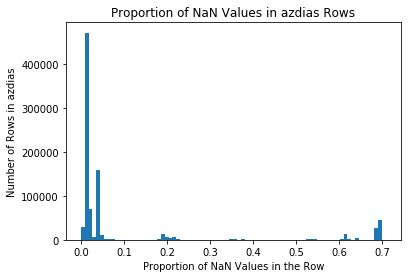

In [21]:
plt.hist(missing_perct, bins=80);

plt.xlabel('Proportion of NaN Values in the Row')
plt.ylabel('Number of Rows in azdias')
plt.title('Proportion of NaN Values in azdias Rows')

We decide that we only want rows (in our AZDIAS dataset) that have strictly less than 5% of percentage of missing values. We can see from the bar chart above that this row-wise threshold will still preserve the vast majority of the dataset.

In [22]:
azdias_cleaned = azdias[missing_perct < 0.05]

In [23]:
azdias_cleaned.shape

(742816, 366)

We can see that almost 17% of the rows have been removed from the original dataset. 

In [24]:
azdias_cleaned.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


Column-wise cleaning

In [32]:
# Find the percentage of missing values NaN in each column of AZDIAS
missing_perct_col = azdias_cleaned.isnull().mean(axis=0)

In [33]:
print(missing_perct_col)

LNR                           0.000000
AGER_TYP                      0.000000
AKT_DAT_KL                    0.000000
ALTER_HH                      0.000000
ALTER_KIND1                   0.906531
ALTER_KIND2                   0.966871
ALTER_KIND3                   0.992967
ALTER_KIND4                   0.998611
ALTERSKATEGORIE_FEIN          0.230042
ANZ_HAUSHALTE_AKTIV           0.000000
ANZ_HH_TITEL                  0.004185
ANZ_KINDER                    0.000000
ANZ_PERSONEN                  0.000000
ANZ_STATISTISCHE_HAUSHALTE    0.000000
ANZ_TITEL                     0.000000
ARBEIT                        0.003973
BALLRAUM                      0.000614
CAMEO_DEU_2015                0.002761
CAMEO_DEUG_2015               0.002761
CAMEO_INTL_2015               0.002761
CJT_GESAMTTYP                 0.000000
CJT_KATALOGNUTZER             0.000000
CJT_TYP_1                     0.000000
CJT_TYP_2                     0.000000
CJT_TYP_3                     0.000000
CJT_TYP_4                

Text(0.5,1,'Proportion of NaN Values in azdias Columns')

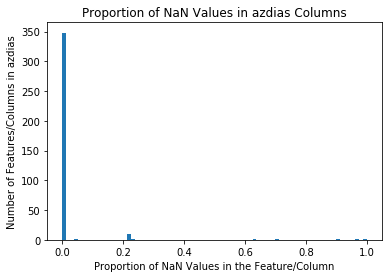

In [34]:
plt.hist(missing_perct_col, bins=80);

plt.xlabel('Proportion of NaN Values in the Feature/Column')
plt.ylabel('Number of Features/Columns in azdias')
plt.title('Proportion of NaN Values in azdias Columns')

Using the same 5% threshold we will keep most of the data while excluding columns with NaN values that will not help trainig our model.

In [37]:
col_to_drop = missing_perct_col[missing_perct_col > 0.05].index

In [38]:
col_to_drop

Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'],
      dtype='object')

In [39]:
azdias_cleaned.drop(labels=col_to_drop, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [40]:
azdias_cleaned.shape

(742816, 350)

16 columns have been removed from the original dataset

In [42]:
azdias_cleaned.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


### Customer dataset cleaning

Row-wise cleaning

In [6]:
# Find the percentage of missing values NaN in each row of customers
missing_perct = customers.isnull().mean(axis=1)

Text(0.5,1,'Proportion of NaN Values in customers Rows')

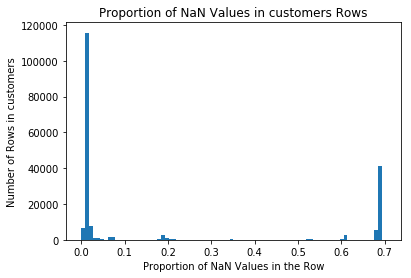

In [7]:
plt.hist(missing_perct, bins=80);

plt.xlabel('Proportion of NaN Values in the Row')
plt.ylabel('Number of Rows in customers')
plt.title('Proportion of NaN Values in customers Rows')

We can see that using the same threshold of 5% as before, we will keep the vast majority of the dataset. 

In [8]:
customers_cleaned = customers[missing_perct < 0.05]

In [9]:
customers_cleaned.shape

(132068, 369)

before perfoming any column cleaning we need to drop the three columns that are not contained in azdias

In [10]:
customers_cleaned.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Column-wise cleaning 

In [11]:
# Find the percentage of missing values NaN in each column of Customers
missing_perct_col = customers_cleaned.isnull().mean(axis=0)

In [12]:
print(missing_perct_col)

LNR                           0.000000
AGER_TYP                      0.000000
AKT_DAT_KL                    0.000000
ALTER_HH                      0.000000
ALTER_KIND1                   0.925251
ALTER_KIND2                   0.968501
ALTER_KIND3                   0.992133
ALTER_KIND4                   0.998463
ALTERSKATEGORIE_FEIN          0.031279
ANZ_HAUSHALTE_AKTIV           0.000000
ANZ_HH_TITEL                  0.015219
ANZ_KINDER                    0.000000
ANZ_PERSONEN                  0.000000
ANZ_STATISTISCHE_HAUSHALTE    0.000000
ANZ_TITEL                     0.000000
ARBEIT                        0.003824
BALLRAUM                      0.000212
CAMEO_DEU_2015                0.001355
CAMEO_DEUG_2015               0.001355
CAMEO_INTL_2015               0.001355
CJT_GESAMTTYP                 0.000000
CJT_KATALOGNUTZER             0.000000
CJT_TYP_1                     0.000000
CJT_TYP_2                     0.000000
CJT_TYP_3                     0.000000
CJT_TYP_4                

Text(0.5,1,'Proportion of NaN Values in customers Columns')

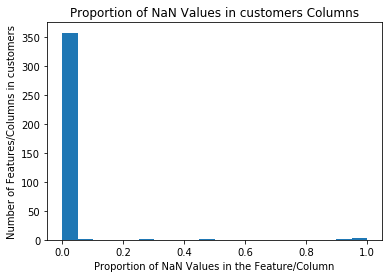

In [13]:
plt.hist(missing_perct_col, bins=20);

plt.xlabel('Proportion of NaN Values in the Feature/Column')
plt.ylabel('Number of Features/Columns in customers')
plt.title('Proportion of NaN Values in customers Columns')

We drop the columns dropped in azdias in order to have the sae number of columns (features) across the two datasets.

In [14]:
customers_cleaned.drop(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'], axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
customers_cleaned.shape

(132068, 350)

After performing cleaning dropping the vast majority of null values, the two datasets now have the same number of columns.

In [16]:
customers_cleaned.head()



,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4
2,143872,-1,1.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,...,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4
3,143873,1,1.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,...,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,1,4
4,143874,-1,1.0,20.0,7.0,0.0,0.0,4.0,7.0,0.0,...,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3
5,143888,1,1.0,11.0,1.0,0.0,0.0,2.0,1.0,0.0,...,4.0,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3


# Reload datasets

In [17]:
# saving azdias_cleaned in local
# azdias_cleaned.to_pickle('azdias_cleaned.pkl')
# customers_cleaned.to_pickle('customers_cleaned.pkl')

In [3]:
# loading saved datasets 
azdias_cleaned = pd.read_pickle('azdias_cleaned.pkl')
customers_cleaned = pd.read_pickle('customers_cleaned.pkl')

# Handle unknown and null values
In the following section, we handle unkown values by using helper fuctions from https://github.com/AilingLiu/Machine-Learning-Engineer-Nanodegree-Program-Udacity, while we impute null values with the mode.

### Handle unkown values

In [18]:
# reference: https://github.com/AilingLiu/Machine-Learning-Engineer-Nanodegree-Program-Udacity
from utils.preprocess import (read_data,
                   listtodict,
                  codetonan,
                  encode_df)

In [19]:
# reference: https://github.com/AilingLiu/Machine-Learning-Engineer-Nanodegree-Program-Udacity
def get_unknown():
    
    feat_info = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header=1)
    feat_att = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
#     feat_info.drop(feat_info.columns[0], axis=1, inplace=True) #dropping the first empty column
#     feat_att.drop(feat_att.columns[0], axis=1, inplace=True)#dropping the first empty column

    # generate a summary of features where Meaning is unknown
    mask = feat_att['Meaning'].str.contains('unknown', case=False, na=False)
    unknown_code = feat_att.loc[mask, :].groupby('Attribute')['Value'].unique().to_frame('missing_or_unknown')
    unknown_code = unknown_code.join(feat_info[['Attribute', 'Description']].set_index('Attribute'), how='left')
    
    #found ['XX', 'X'] as missing values too
    ta = pd.DataFrame([[['X, XX'], 'CAMEO']]*2, index= ['CAMEO_DEU_2015', 'CAMEO_INTL_2015'], 
                  columns=['missing_or_unknown', 'Description'])
    
    unknown_code.loc['CAMEO_DEUG_2015', 'missing_or_unknown'] = ['-1, X, XX']
    
    return pd.concat([unknown_code, ta])

In [20]:
unknown_code = get_unknown()
unknown_code.head(5)

,missing_or_unknown,Description
AGER_TYP,[-1],best-ager typology
ALTERSKATEGORIE_GROB,"[-1, 0]",age through prename analysis
ALTER_HH,[0],main age within the household
ANREDE_KZ,"[-1, 0]",gender
BALLRAUM,[-1],distance to the next metropole


In [21]:
unknown_code.index.rename('Attribute', inplace=True)
unknown_code.reset_index().to_csv('unknown_summary.csv')


In [22]:
# handle unkown values in the cleaned general population dataset
codetonan(azdias_cleaned, unknown_code)


Total execution time of this procedure: 190.30 seconds


In [23]:
# handle unkown values in the cleaned customers dataset
codetonan(customers_cleaned, unknown_code)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Total execution time of this procedure: 62.05 seconds


### Re-encode categorical values

We call a function to encode the categorical variables into integers using as a reference: https://github.com/AilingLiu/Machine-Learning-Engineer-Nanodegree-Program-Udacity

In [24]:
# We transform the categorical variables of both general population and customers dataset
encoded_azdias = encode_df(azdias_cleaned)
encoded_customers = encode_df(customers_cleaned)

/home/workspace/utils/preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CAMEO_DEU'] = df['CAMEO_DEU_2015'].apply(lambda x: strtoint(x) if x is not np.nan else x)
/home/workspace/utils/preprocess.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['CAMEO_DEUG']= df['CAMEO_DEUG_2015'].astype('float64')
/home/workspace/utils/preprocess.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

### Impute missing values
We use the mode as a central tendency measure to fill the null values in both datasets. 
This choice is related to the fact that both datasets include categorical variables.

In [29]:
imputer = Imputer(missing_values=np.nan, strategy='most_frequent')

In [ ]:
azdias_imputed = pd.DataFrame(imputer.fit_transform(encoded_azdias))
customers_imputed = pd.DataFrame(imputer.fit_transform(encoded_customers))

## Normalize data (Scaling)
The two datasets contain only numerical data so we need to standardize the scale of the numerical columns in order to consistently compare the values of different features and correctly apply Principal component analysis. We can use a MinMaxScaler to transform the numerical values so that they all fall between 0 and 1. We prefer MinMax scaler because the bounderies of many variables in both datasets are well know since they fall within pre-determined ranges.

In [ ]:
# scale numerical features into a normalized range, 0-1
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

# store them in this dataframe
azdias_scaled=pd.DataFrame(scaler.fit_transform(azdias_imputed.astype(float)))
customers_scaled=pd.DataFrame(scaler.fit_transform(customers_imputed.astype(float)))

# get same features and indices
azdias_scaled.columns=azdias_imputed.columns
azdias_scaled.index=azdias_imputed.index

customers_scaled.columns=customers_imputed.columns
customers_scaled.index=customers_imputed.index

azdias_scaled.head()

In [ ]:
azdias_scaled.head()

In [ ]:
azdias_scaled.describe()

In [ ]:
customers_scaled.head()

In [ ]:
customers_scaled.describe()

In [ ]:
# For next use in Part 1 and 2

azdias_scaled.to_pickle('azdias_scaled.pkl')
customers_scaled.to_pickle('customers_scaled.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

# Data Model
Now, the data is ready to be fed into a machine learning model!

Each data point has X features, which means the data is X-dimensional. Clustering algorithms rely on finding clusters in n-dimensional feature space. For higher dimensions, an algorithm like k-means has a difficult time figuring out which features are most important, and the result is, often, noisier clusters.

Some dimensions are not as important as others and we really want to find the features that help to separate and group data. We want to find features that cause the most variance in the dataset!

So, before I cluster this data, I’ll want to take a dimensionality reduction step. My aim will be to form a smaller set of features that will better help to separate our data. The technique I’ll use is called PCA or principal component analysis

#### Dimensionality Reduction
PCA attempts to reduce the number of features within a dataset while retaining the “principal components”, which are defined as weighted, linear combinations of existing features that are designed to be linearly independent and account for the largest possible variability in the data! You can think of this method as taking many features and combining similar or redundant features together to form a new, smaller feature set. These principal components are meant to be linearly independent (solving the problem of highly correlated features) and account for the largest possible variability in the data.

Three types of model attributes are contained within the PCA model.

mean: The mean that was subtracted from a component in order to center it.

- components_: The makeup of the principal components
- singular_values_: The singular values of the components for the PCA transformation. This does not exactly give the % variance from the original feature space, but can give the % variance from the projected feature space.


From singular_values_, we can get an approximation of the data variance that is covered in the first n principal components. The approximate explained variance is given by the formula: the sum of squared singular values for all top n components over the sum over squared singular values for all components:

$$\begin{equation*}
\frac{\sum_{n}^{ } s_n^2}{\sum s^2}
\end{equation*}$$

From components_, we can learn more about the combinations of original features that make up each principal component.


### PCA on general population

In [ ]:
from sklearn.decomposition import PCA

# this is current features - 1 -> n_components == min(n_samples, n_features) - 1
pca = PCA()

In [ ]:
azdias_pca = pca.fit_transform(azdias_scaled)

In [ ]:
#v: The makeup of the principal components
v_azdias = pca.components_

In [ ]:
#s: The singular values
s_azdias = pca.singular_values_

In [ ]:
# looking at top 5 components
n_principal_components = 5
N_COMPONENTS=349 # min(n_samples, n_features) - 1

start_idx = N_COMPONENTS - n_principal_components

# print a selection of s
print(s.iloc[start_idx:, :])

In [ ]:
# Calculate the explained variance for the top n principal components
def explained_variance(s, n_top_components):
    '''Calculates the approx. data variance that n_top_components captures.
       :param s: A dataframe of singular values for top components; 
           the top value is in the last row.
       :param n_top_components: An integer, the number of top components to use.
       :return: The expected data variance covered by the n_top_components.'''
    
    start_idx = N_COMPONENTS - n_top_components  ## 349-300 = 49, for example
    # calculate approx variance
    exp_variance = np.square(s.iloc[start_idx:,:]).sum()/np.square(s).sum()
    
    return exp_variance[0]

In [ ]:
n_top_components = 50 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s_azdias, n_top_components)
print('Explained variance: ', exp_variance)

#### Component makeup for the general population dataset
We can now examine the makeup of each PCA component based on the weightings of the original features that are included in the component. The following code shows the feature-level makeup of the first component.

Note that the components are again ordered from smallest to largest and so I am getting the correct rows by calling N_COMPONENTS-1 to get the top, 1, component.

In [ ]:
import seaborn as sns

def display_component(v, features_list, component_num, n_weights=10):
    
    # get index of component (last row - component_num)
    row_idx = N_COMPONENTS-component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

In [ ]:
# display makeup of first component
num=2
display_component(v_azdias, azdias_scaled.columns.values, component_num=num, n_weights=10)

### PCA on customers

In [ ]:
customers_pca = pca.fit_transform(customers_scaled)

In [ ]:
#v: The makeup of the principal components
v_customers = pca.components_

In [ ]:
#s: The singular values
s_customers = pca.singular_values_

In [ ]:
# looking at top 5 components
n_principal_components = 5
N_COMPONENTS=349 # min(n_samples, n_features) - 1

start_idx = N_COMPONENTS - n_principal_components

# print a selection of s
print(s.iloc[start_idx:, :])

In [ ]:
n_top_components = 50 # select a value for the number of top components

# calculate the explained variance
exp_variance = explained_variance(s_customers, n_top_components)
print('Explained variance: ', exp_variance)

#### Component makeup for the customers dataset

In [ ]:
# display makeup of first component
num=2
display_component(v_customers, customers_scaled.columns.values, component_num=num, n_weights=10)

# Reduce Dimensions to X feature space

In [ ]:
def reduce_dimension(df, n=150):
    
    pca = PCA(n_components=n)
    
    reduced_df = pca.fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df)
    
    print('The variance in the data explained by the principal components after employing PCA is equal to ' + str(pca.explained_variance_ratio_.sum())) 
    
    return reduced_df

In [ ]:
reduced_azdias = reduce_dimension(azdias_scaled, n=150)

In [ ]:
reduced_customers = reduce_dimension(customers_scaled, n=150)

In [ ]:
reduced_azdias.shape

In [ ]:
reduced_customers.shape

# K-means
Now, you’ll use the unsupervised clustering algorithm, k-means, to segment customers using their PCA attributes, which are in the transformed DataFrame we just created. K-means is a clustering algorithm that identifies clusters of similar data points based on their component makeup. we have reduced the feature space to X PCA components, and we’ll cluster on this transformed dataset.
We will use the elbow method to find the optimal number of clusters

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
def apply_kmeans(data, k):
    """
    Computes the average within-cluster distance for a specified number of clusters (n_clusters)
    
    INPUT:
    - data (array): the resultin array from PCA's fit_transform function
    - n_clusters (int): the number of clusters for applying k-means
    
    OUTPUT:
    None
    """


        
    kmeans = KMeans(n_clusters=k)
    
    model = kmeans.fit(data)
    
    return abs(model.score(data))

In [ ]:
within_cluster_distances = []
clusters = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for cluster_num in clusters:
    within_cluster_distances.append(apply_kmeans(reduced_azdias.sample(20000), cluster_num))
    

    
plt.plot(clusters, distances, linestyle='-', marker='x', color='blue')

plt.xticks(ticks=clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance to centroid (within-cluster distance)')
plt.title('The Elbow Method')

plt.show()

From the graph above, using the Elbow Method, we come to the conclusion that X is the optimal number of clusters for k-means clustering on azdias.



In [ ]:
n_clusters = 12

kmeans = KMeans(n_clusters=n_clusters)

In [ ]:
# AZDIAS (the general population)

azdias_preds = kmeans.fit_predict(reduced_azdias)

In [ ]:
azdias_clustered = pd.DataFrame(azdias_preds, columns = ['Cluster'])

azdias_clustered.to_pickle('azdias_clustered.pkl')

In [ ]:
# CUSTOMERS (the customer base)

customers_preds = kmeans.fit_predict(reduced_customers)

In [ ]:
customers_clustered = pd.DataFrame(customers_preds, columns = ['Cluster'])

customers_clustered.to_pickle('customers_clustered.pkl')

### Comparing Clusters: General Population (azdias) vs Customer Base (customers)


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')